In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame
arr = np.array

# 读取数据

In [2]:
dirPath = "data preprocessed\\unnormalized"

trainSet_origin = np.loadtxt(dirPath + '\\train.csv', delimiter=",")
validateSet_origin = np.loadtxt(dirPath + '\\validate.csv', delimiter=",")
testSet = np.loadtxt(dirPath + '\\test.csv', delimiter=",")

trainSet_origin.shape, validateSet_origin.shape, testSet.shape

((33600, 18), (14400, 18), (12000, 17))

划分数据集特征和标签：

In [3]:
trainSet, trainSetLabel = trainSet_origin[:, :-1], trainSet_origin[:, -1]
validateSet, validateSetLabel = validateSet_origin[:, :-1], validateSet_origin[:, -1]
trainSet.shape, validateSet.shape

((33600, 17), (14400, 17))

# 实现评测指标

In [4]:
def calcF1(predictLabel, realLabel, printRes=False):
    '''给定算法得到的分类结果和实际的分类结果，计算评测指标
    注意：标签为1则为正标签，标签不为1则为负标签'''
    def safeDivide(a, b):
        '''子函数：当分母为0时返回除式结果为 -1'''
        return a/b if b != 0 else 0
    
    TP = Counter(np.logical_and(predictLabel==1, realLabel==1))[True]
    FN = Counter(np.logical_and(predictLabel!=1, realLabel==1))[True]
    FP = Counter(np.logical_and(predictLabel==1, realLabel!=1))[True]
    if(printRes):
        print("TP FN FP", TP, FN, FP)
    F1 = safeDivide(2*TP, 2*TP+FN+FP)
    return F1

print('test 1: normal one')
calcF1(arr([1, 1, 0, 0]), arr([1, 0, 1, 0]), True)
print('\ntest 2: may have zero division error')
calcF1(arr([0, 0, 1, 0]), arr([1, 0, 1, 0]), True)

test 1: normal one
TP FN FP 1 1 1


0.5


test 2: may have zero division error
TP FN FP 1 1 0


0.6666666666666666

# KNN

In [5]:
def knn_classify(dataSet, labels, k, inputVector):
    '''使用knn对输入的向量进行分类，使用欧式距离'''
    #得到输入向量与数据集的差值的平方
    diffMat = (dataSet - inputVector)**2
    #计算每一行上元素的和并开方，得到距离向量
    distances = np.sqrt(diffMat.sum(axis=1))
    #print("输入向量与训练集每个向量的距离依次为：",list(distances))
    #得到 K个近邻的下标
    kNeighborsIndex  = distances.argpartition(k-1)[0:k]
    #返回分类结果
    return Counter(labels[kNeighborsIndex]).most_common(1)[0][0]

##############测试程序#######################
knn_classify(arr([[1,1,0,0],
              [0,1,1,1],
              [1,0,0,1]]), arr([1, 0, 1]), 1, arr([0,1,1,0]))
##############测试程序#######################

0

# 调参

所调参数只有K。

In [6]:
def run_knn_classify(dataSet, k):
    ansLabel = []
    for i in tnrange(len(dataSet), leave=False):
        ansLabel.append(knn_classify(trainSet, trainSetLabel, k, dataSet[i]))
    return arr(ansLabel)

def getTestF1(k):
    ansLabel = run_knn_classify(validateSet, k)
    return calcF1(ansLabel, validateSetLabel)

In [9]:
testRange = np.arange(1, 50)
testRange

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [ ]:
F1s = []
for k in tnrange(1, len(testRange)+1):
    F1s.append(getTestF1(k))

In [19]:
bestK = testRange[np.argmax(F1s)]
bestK, np.max(F1s)

(1, 0.87826086956521743)

In [20]:
InteractiveShell.ast_node_interactivity = "none"

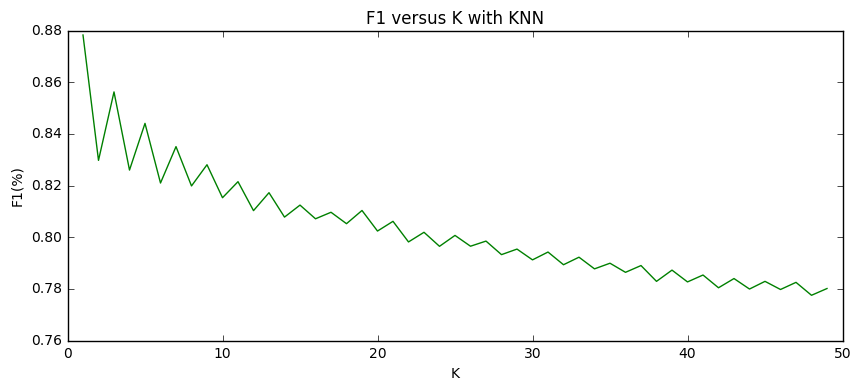

In [21]:
fig,ax = plt.subplots() 
fig.set_size_inches(10, 4)
plt.plot(testRange, F1s, 'g')
plt.xlabel('K')
plt.ylabel('F1(%)')
plt.title("F1 versus K with KNN")
plt.show()
plt.close()

In [22]:
InteractiveShell.ast_node_interactivity = "all"

# 应用算法到测试集

In [25]:
ansLabel = run_knn_classify(testSet, bestK)
np.savetxt('.\\rank\\47_v2.csv', ansLabel, fmt="%d", delimiter="\n")

In [29]:
Counter(ansLabel)
one = Counter(ansLabel)[1.0]
zero = Counter(ansLabel)[0.0]
one/(one + zero)

Counter({0.0: 6123, 1.0: 5877})

0.48975